In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# jupyter notebook-display maximum columns
from IPython.display import display
pd.options.display.max_columns = None 

# jupyter notebook-display multiple outputs from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Description
We are asked to predict the probability that an online transaction is fraudulent, as denoted by the binary target `isFraud`.
The data is broken into two files identity and transaction, which are joined by `TransactionID`. Not all transactions have corresponding identity information.

#### Categorical Features - Transaction
`ProductCD`, `card1 - card6`, `addr1, addr2`

`P_emaildomain`, `R_emaildomain`, `M1 - M9`

#### Categorical Features - Identity
`DeviceType`, `DeviceInfo`,  `id_12 - id_38`

The `TransactionDT` feature is a timedelta from a given reference datetime (not an actual timestamp).

#### Files
train_{transaction, identity}.csv - the training set

test_{transaction, identity}.csv - the test set (to predict the isFraud value for these observations)

sample_submission.csv - a sample submission file in the correct format

## Additional info from Vesta
#### Transaction Table
`TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

`TransactionAMT`: transaction payment amount in USD

`ProductCD`: product code, the product for each transaction

`card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

`addr`: address of purchaser. `addr1` as billing region(billing zip code), `addr2` as billing country

`dist`: distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.

`P_ and (R__) emaildomain`: purchaser and recipient email domain

`C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

`D1-D15`: timedelta, such as days between previous transaction, etc.

`M1-M9`: match, such as names on card and address, etc.

`Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

Why would a transaction not have a row of identity? - For various technical reasons, it's challenging to collect all identity information at the real-time transactions

#### Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

In [138]:
df_train_id = pd.read_csv('./input/train_identity.csv')
df_train_tr = pd.read_csv('./input/train_transaction.csv')
df_test_id = pd.read_csv('./input/test_identity.csv')
df_test_tr = pd.read_csv('./input/test_transaction.csv')

In [139]:
df_train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [140]:
df_train_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [141]:
df_train_tr.shape, df_train_id.shape
df_test_tr.shape, df_test_id.shape

((590540, 394), (144233, 41))

((506691, 393), (141907, 41))

In [142]:
df= pd.merge(df_train_tr, df_train_id, on = 'TransactionID', how = 'left')
df.shape

df_test = pd.merge(df_test_tr, df_test_id, on = 'TransactionID', how = 'left')
df_test.shape

(590540, 434)

(506691, 433)

In [143]:
del df_train_id, df_train_tr, df_test_id, df_test_tr

In [144]:
fraud_records = df.isFraud[df.isFraud == 1].count()
print (f"training data has {fraud_records} fraud records out of total {df.shape[0]} records i.e. {round(100*fraud_records/df.shape[0],2)}%")

# print('following features have nulls more than ')
# df.isna().sum()[df.isna().sum()>(df.shape[0]-fraud_records)] # top10 features with null values present

training data has 20663 fraud records out of total 590540 records i.e. 3.5%


In [145]:
100*df['TransactionID'][df.isFraud==1 & df['TransactionID'].isnull()].count()/df['TransactionID'].isnull().count()
df['TransactionID'].isnull().count()

96.50099908558269

590540

In [146]:
# Function to get basic details about dataframe features
def feature_summary(df):

    all = df.columns.tolist()
    first_cut = {'feature_name':[],'dtype':[],'unique_values':[], 'records':[],'nulls':[], '%nulls':[],'%not_nulls':[], '%fraud_rows':[], '%fraud_in_nulls':[], '%fraud_in_not_nulls':[]}
    for feature in all:

        first_cut['feature_name'].append(feature)
        first_cut['dtype'].append(df[feature].dtype)
        first_cut['records'].append(df.shape[0])
        first_cut['unique_values'].append(df[feature].nunique(dropna=False))
        first_cut['nulls'].append(df[feature].isnull().sum())
        first_cut['%nulls'].append(100*df[feature].isnull().sum()/df.shape[0])
        first_cut['%not_nulls'].append(100*df[feature].notnull().sum()/df.shape[0])

        first_cut['%fraud_rows'].append(100*df[feature][df.isFraud==1].size/df.shape[0])

        #Fraud distribution in nulls
        nulls = df[feature].isnull().sum()
        not_nulls = df[feature].notnull().sum()
        frauds_in_nulls = df['isFraud'][(df[feature].isnull()) & (df.isFraud==1)].size
        frauds_in_not_nulls = df['isFraud'][(df[feature].notnull()) & (df.isFraud==1)].size

        if nulls != 0:
            first_cut['%fraud_in_not_nulls'].append(100*frauds_in_not_nulls/not_nulls)
        else:
            first_cut['%fraud_in_not_nulls'].append(100)

        if nulls !=0:
            first_cut['%fraud_in_nulls'].append(100*frauds_in_nulls/nulls)
        else:
            first_cut['%fraud_in_nulls'].append(0)
    features = pd.DataFrame(first_cut)    
    return features

In [147]:
%%time
starting_summary = feature_summary(df)
starting_summary

Wall time: 19.4 s


,feature_name,dtype,unique_values,records,nulls,%nulls,%not_nulls,%fraud_rows,%fraud_in_nulls,%fraud_in_not_nulls
0,TransactionID,int64,590540,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
1,isFraud,int64,2,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
2,TransactionDT,int64,573349,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
3,TransactionAmt,float64,20902,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
4,ProductCD,object,5,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
5,card1,int64,13553,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
6,card2,float64,501,590540,8933,1.512683,98.487317,3.499001,4.735251,3.480013
7,card3,float64,115,590540,1565,0.265012,99.734988,3.499001,2.492013,3.501677
8,card4,object,5,590540,1577,0.267044,99.732956,3.499001,2.599873,3.501408
9,card5,float64,120,590540,4259,0.721204,99.278796,3.499001,4.930735,3.488600


# Filling Nulls columns 5-10

In [148]:
# make a sample check to see records for largest value counts of card1
df.card1.value_counts().nlargest(5)
max_tr_card1_id = df.card1.value_counts().nlargest(5).index.tolist()[0]

print(f'max transactions observed for card1#{max_tr_card1_id}')
df[df.card1 == max_tr_card1_id].head()
for card in ['card2' ,'card3', 'card4', 'card5', 'card6' ]:
    print (f'unique values in {card} column for card1#{max_tr_card1_id} are {df[df.card1 == max_tr_card1_id][card].nunique()}')

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
Name: card1, dtype: int64

max transactions observed for card1#7919


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
526,2987526,0,95442,201.0,W,7919,194.0,150.0,mastercard,202.0,debit,327.0,87.0,324.0,NaN,NaN,NaN,3.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,38.0,3.0,313.0,313.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,398.0,398.0,NaN,NaN,NaN,398.0,T,T,T,M1,F,F,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,0.0,0.0,0.0,1.0,6.0,0.0,4.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,100.0,600.000000,400.0,100.0,600.000000,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
843,2987843,0,105504,117.0,W,7919,194.0,150.0,mastercard,202.0,debit,384.0,87.0,NaN,NaN,NaN

unique values in card2 column for card1#7919 are 1
unique values in card3 column for card1#7919 are 1
unique values in card4 column for card1#7919 are 1
unique values in card5 column for card1#7919 are 2
unique values in card6 column for card1#7919 are 1


#### So its pretty clear that card1 values are unique and rest of the card2-6 associated values are also mostly unique. We can use this information to fill-in the nulls in these columns

In [149]:
#Lets make a pivot table with cards columns. We will use this table to fill in possible nulls by checking 'card2-6' values associated with 'card1'
dfg_card = df.pivot_table(index =['card1','card2' ,'card3', 'card4', 'card5', 'card6'], values = 'isFraud')
dfg_card.reset_index(inplace = True)
dfg_card.head()

,card1,card2,card3,card4,card5,card6,isFraud
0,1000,555.0,185.0,mastercard,224.0,debit,0.0
1,1001,555.0,150.0,visa,226.0,debit,0.0
2,1004,583.0,150.0,visa,226.0,credit,0.0
3,1005,543.0,150.0,mastercard,117.0,debit,0.0
4,1006,399.0,150.0,american express,146.0,credit,0.0


In [150]:
dfcopy = df.copy()

In [151]:
#Initials Nan's in card2-6 columns
print(f"Initial count of NaN's in card columns:")
df[['card2' ,'card3', 'card4', 'card5', 'card6']].isnull().sum()

Initial count of NaN's in card columns:


card2    8933
card3    1565
card4    1577
card5    4259
card6    1571
dtype: int64

In [152]:
#Replacing Nan's in card2-6 columns with values corresponding to card1 in dfg_card
for card in ['card2' ,'card3', 'card4', 'card5', 'card6']:
    print(f' filling-in {card} Nulls')
    
    df[card] = df.apply(
        lambda row: dfg_card[card][dfg_card.card1 == row.card1].mode().tolist()[0] if ((pd.isnull(row[card])) and (len(dfg_card[card][dfg_card.card1 == row.card1].mode().tolist()) !=0))  else row[card],axis=1) # pd.isnull(row[card]) is used as row[card].isnull() is throwing error for card4(type str)

print(f"Count of NaN's in card columns after filling in from dfg_card:")
df[['card2' ,'card3', 'card4', 'card5', 'card6']].isnull().sum()

 filling-in card2 Nulls
 filling-in card3 Nulls
 filling-in card4 Nulls
 filling-in card5 Nulls
 filling-in card6 Nulls
Count of NaN's in card columns after filling in from dfg_card:


card2    4743
card3      29
card4      40
card5    1137
card6      35
dtype: int64

In [153]:
# Next we will use combination of card4, card6 values to triangulate missing values in other card columns
for card in ['card2' ,'card3', 'card4', 'card5', 'card6']:
    print(f' filling-in {card} Nulls')
    
    df[card] = df.apply(
        lambda row: dfg_card[card][(dfg_card.card4 == row.card4) & (dfg_card.card6 == row.card6)].mode()[0] if ((pd.isnull(row[card])) and 
                                                                            (len(dfg_card[card][(dfg_card.card4 == row.card4) & (dfg_card.card6 == row.card6)].mode().tolist()) !=0))   else row[card],axis=1) # pd.isnull(row[card]) is used as row[card].isnull() is throwing error for card4(type str)

print(f"Count of NaN's in card columns after filling in from dfg_card:")
df[['card2' ,'card3', 'card4', 'card5', 'card6']].isnull().sum()

 filling-in card2 Nulls
 filling-in card3 Nulls
 filling-in card4 Nulls
 filling-in card5 Nulls
 filling-in card6 Nulls
Count of NaN's in card columns after filling in from dfg_card:


card2    36
card3    29
card4    40
card5    37
card6    35
dtype: int64

In [154]:
# lets fill rest of the nulls with mode of entire columns 

for feature in ['card2' ,'card3', 'card4', 'card5', 'card6']:
    df[feature] = df[feature].fillna(df[feature].mode()[0])
print(f"Count of NaN's in card columns after filling in from dfg_card:")
df[['card2' ,'card3', 'card4', 'card5', 'card6']].isnull().sum()

Count of NaN's in card columns after filling in from dfg_card:


card2    0
card3    0
card4    0
card5    0
card6    0
dtype: int64

In [155]:
# # convert to categorical 

# to_cat = ['ProductCD','card1', 'card2' ,'card3', 'card4', 'card5', 'card6']
# for feature in to_cat:
#     df[feature]=df[feature].astype('category')

## fill nulls for cols 11-16

In [156]:
# starting with addr1, addr2: we know that addr1 identifies zipcode and addr2 identifies country of billing address
# While card in specific countries may be more susceptible to fraud due to local enforcement practices, 
#zip code of billing address does not look like a suitable feature to influence fraud category
# we can check this by distribution of Frauds by different values of these features

In [157]:
top10_addr1 = df.addr1.value_counts().nlargest(10).index.tolist()
top10_addr2 = df.addr2.value_counts().nlargest(10).index.tolist()

In [158]:
def histogram_feat(feature, df):
    top10 = df[feature].value_counts().nlargest(50).index.tolist()
    xlist = top10
    ylist = []
    for idx in top10:
        total = df[feature][df[feature] == idx].count()
        frauds = df[feature][(df[feature] == idx) & (df.isFraud == 1)].count()
        percent_frauds = round(100*frauds/total, 2)
        ylist.append(percent_frauds)
    return(xlist, ylist)
    

In [159]:
xlist, ylist = histogram_feat('addr1', df)

<BarContainer object of 50 artists>

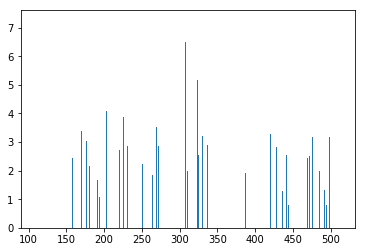

In [160]:
# xlist, ylist
plt.bar(xlist, ylist)

In [161]:
df[df.addr1.isnull()].head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
10,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,credit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0,4.0,4.0,2.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,3.0,3.0,3.0,3.0,4.0,4.0,2.0,2.0,2.0,0.0,2.0,4.0,4.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,90.327904,0.0,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,3.0,3.0,3.0,4.0,4.0,2.0,2.0,1.0,2.0,2.0,2.0,4.0,4.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0

In [162]:
l = df.card1[df.addr1.isnull()].tolist()
l1 = df[(df.card1.isin(l)) & (df.addr1.notnull())].card1.tolist()

In [163]:
len(list(set(l))), len(list(set(l1)))
len(list(set(l)-set(l1)))

(2443, 956)

1487

In [164]:
def crossfill(df, list_index, fill_columns, link_with):
    
    print(f"Count of NaN's in features before filling:")
    print(df[fill_columns].isnull().sum())
    
    temp = df.pivot_table(index =list_index, values = 'isFraud')
    temp.reset_index(inplace = True)
    print(temp.head())
    for feature in fill_columns:
        print(f' filling-in {feature} Nulls')
        df[feature] = df.apply(
            lambda row: temp[feature][(temp[link_with] == row[link_with])].mode()[0] 
            if ((pd.isnull(row[feature])) and (len(temp[feature][(temp[link_with] == row[link_with])].mode().tolist()) !=0)) else row[feature],axis=1) 
    print(f"Count of NaN's in features after filling:")
    print(df[fill_columns].isnull().sum())
    return df
    


In [165]:
dfcopy=df.copy()

In [166]:
list_index = ['card1', 'addr1', 'addr2']
link_with = 'card1'
fill_columns = ['addr1', 'addr2']
#fill nulls
df = crossfill(df, list_index, fill_columns, link_with)

Count of NaN's in features before filling:
addr1    65706
addr2    65706
dtype: int64
   card1  addr1  addr2  isFraud
0   1001  269.0   87.0      0.0
1   1004  299.0   87.0      0.0
2   1004  325.0   87.0      0.0
3   1004  384.0   87.0      0.0
4   1005  181.0   87.0      0.0
 filling-in addr1 Nulls
 filling-in addr2 Nulls
Count of NaN's in features after filling:
addr1    5515
addr2    5515
dtype: int64


In [167]:
#fill rest of addr nulls with -999

df['addr1'] = df['addr1'].fillna(-999)
df['addr2'] = df['addr2'].fillna(-999)
print(df[['addr1', 'addr2']].isnull().sum())

addr1    0
addr2    0
dtype: int64


In [168]:
starting_summary.iloc[15:30]

,feature_name,dtype,unique_values,records,nulls,%nulls,%not_nulls,%fraud_rows,%fraud_in_nulls,%fraud_in_not_nulls
15,P_emaildomain,object,60,590540,94456,15.994852,84.005148,3.499001,2.953756,3.602817
16,R_emaildomain,object,61,590540,453249,76.751617,23.248383,3.499001,2.081858,8.177521
17,C1,float64,1657,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
18,C2,float64,1216,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
19,C3,float64,27,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
20,C4,float64,1260,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
21,C5,float64,319,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
22,C6,float64,1328,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
23,C7,float64,1103,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000
24,C8,float64,1253,590540,0,0.000000,100.000000,3.499001,0.000000,100.000000


## filling nulls in email domains
since %frauds in null email domains are less than notnull email domains, we can safely fill these nulls with 'unknown'

In [170]:
df.P_emaildomain = df.P_emaildomain.fillna('unknown')
df.R_emaildomain = df.R_emaildomain.fillna('unknown')
df[['P_emaildomain', 'R_emaildomain']].isnull().sum()

P_emaildomain    0
R_emaildomain    0
dtype: int64

In [172]:
starting_summary.iloc[31:46]

,feature_name,dtype,unique_values,records,nulls,%nulls,%not_nulls,%fraud_rows,%fraud_in_nulls,%fraud_in_not_nulls
31,D1,float64,642,590540,1269,0.214888,99.785112,3.499001,3.624901,3.498730
32,D2,float64,642,590540,280797,47.549192,52.450808,3.499001,4.555960,2.540816
33,D3,float64,650,590540,262878,44.514851,55.485149,3.499001,4.201188,2.935647
34,D4,float64,809,590540,168922,28.604667,71.395333,3.499001,3.608766,3.455023
35,D5,float64,689,590540,309841,52.467403,47.532597,3.499001,3.157426,3.876038
36,D6,float64,830,590540,517353,87.606767,12.393233,3.499001,2.502160,10.545589
37,D7,float64,598,590540,551623,93.409930,6.590070,3.499001,2.696226,14.877817
38,D8,float64,12354,590540,515614,87.312290,12.687710,3.499001,2.489459,10.446307
39,D9,float64,25,590540,515614,87.312290,12.687710,3.499001,2.489459,10.446307
40,D10,float64,819,590540,76022,12.873302,87.126698,3.499001,5.111678,3.260722


## filling nulls in D values
these counts indicate information e.g timedelta from previous transaction. we can fill with either mode/median for same credit card number.Lets try with mode

In [173]:
list_index = ['card1', 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11', 'D12', 'D13', 'D14', 'D15']
link_with = 'card1'
fill_columns = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11', 'D12', 'D13', 'D14', 'D15']

#fill nulls
df = crossfill(df, list_index, fill_columns, link_with)

Count of NaN's in features before filling:
D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64
Empty DataFrame
Columns: [card1, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15]
Index: []
 filling-in D1 Nulls
 filling-in D2 Nulls
 filling-in D3 Nulls
 filling-in D4 Nulls
 filling-in D5 Nulls
 filling-in D6 Nulls
 filling-in D7 Nulls
 filling-in D8 Nulls
 filling-in D9 Nulls
 filling-in D10 Nulls
 filling-in D11 Nulls
 filling-in D12 Nulls
 filling-in D13 Nulls
 filling-in D14 Nulls
 filling-in D15 Nulls
Count of NaN's in features after filling:
D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64


In [176]:
df[df.D1.isnull()].sum()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
202865,3189865,0,4645309,39.950,W,7207,111.0,150.0,visa,226.0,debit,204.0,87.0,NaN,NaN,unknown,unknown,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207665,3194665,0,4782311,59.000,W,13374,111.0,150.0,mastercard,224.0,debit,205.0,87.0,561.0,NaN,gmail.com,unknown,2.0,1

In [203]:
df[(df.card1 == 13374) & (df.D6.notnull())].D6

232415    0.0
283734    0.0
283737    0.0
283739    0.0
283740    0.0
283743    0.0
Name: D6, dtype: float64

In [201]:
df[(df.card1 == 13374) & (df.D4.notnull())]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
18890,3005890,0,502242,33.95,W,13374,111.0,150.0,mastercard,224.0,debit,205.0,87.0,NaN,NaN,gmail.com,unknown,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23217,3010217,0,59

In [208]:
df.D1.value_counts()

0.0      280130
1.0        8634
2.0        4969
3.0        3954
4.0        3570
7.0        3455
6.0        3164
5.0        3076
14.0       2979
8.0        2637
28.0       2634
9.0        2387
13.0       2369
42.0       2294
15.0       2222
11.0       2119
10.0       2115
12.0       2071
29.0       2039
21.0       2023
35.0       1964
16.0       1853
30.0       1812
27.0       1791
22.0       1715
20.0       1709
18.0       1707
17.0       1656
43.0       1623
26.0       1607
          ...  
624.0       144
583.0       143
587.0       143
629.0       143
590.0       143
611.0       142
628.0       140
592.0       140
605.0       138
594.0       136
597.0       136
585.0       134
599.0       131
626.0       129
615.0       128
622.0       125
612.0       124
593.0       124
614.0       124
613.0       122
598.0       122
600.0       121
618.0       112
620.0       111
591.0       110
621.0       109
619.0       107
638.0        79
639.0        42
640.0        14
Name: D1, Length: 641, d

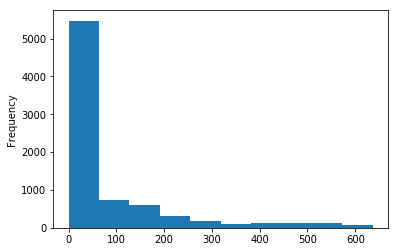

In [216]:
df.D2[df.isFraud==1].plot(kind = 'hist')


In [224]:
round(df.D2[df.isFraud==1].mean(),0)
round(df.D2[df.isFraud==0].mean(),0)
round(df.D2.mean(),0)

round(df.D2[df.isFraud==1].median(),0)
round(df.D2[df.isFraud==0].median(),0)
round(df.D2.median(),0)

round(df.D2[df.isFraud==1].mode(),0)
round(df.D2[df.isFraud==0].mode(),0)
round(df.D2.mode(),0)

78.0

172.0

170.0

16.0

100.0

97.0

0    0.0
dtype: float64

0    0.0
dtype: float64

0    0.0
dtype: float64

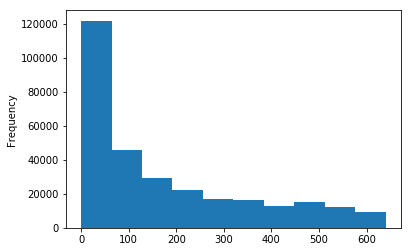

In [217]:
df.D2[df.isFraud==0].plot(kind = 'hist')

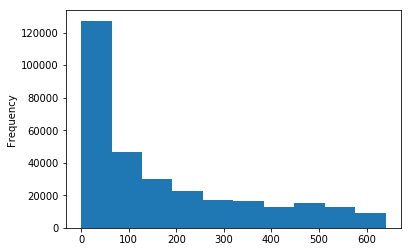

In [225]:
df.D2.plot(kind = 'hist')

In [ ]:
# Median values seems better balance between categories of isFraud

In [294]:
def crossfill_mean(df, list_index, fill_columns, link_with):
    
    print(f"Count of NaN's in features before filling:")
    print(df[fill_columns].isnull().sum())
    
    temp = df.pivot_table(index =list_index, values = fill_columns, aggfunc = np.mean)
    temp.reset_index(inplace = True)
    print(temp.head())
    for feature in fill_columns:
        print(f' filling-in {feature} Nulls')
        df[feature] = df.apply(
            lambda row: temp[feature][(temp[link_with] == row[link_with])].mean() if (pd.isnull(row[feature]))  else row[feature],axis=1) 
    print(f"Count of NaN's in features after filling:")
    print(df[fill_columns].isnull().sum())
    return df

In [295]:
df = dfcopy.copy()
dfcopy = df.copy()

list_index = ['card1']
link_with = 'card1'
fill_columns = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11', 'D12', 'D13', 'D14', 'D15']

#fill nulls
df = crossfill_mean(df, list_index, fill_columns, link_with)

Count of NaN's in features before filling:
D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64
   card1    D1         D10  D11  D12  D13  D14         D15    D2    D3  \
0   1000   0.0    0.000000  NaN  5.0  5.0  0.0    5.000000   NaN   NaN   
1   1001  27.0  336.666667  0.0  NaN  NaN  NaN  336.666667  40.5  25.0   
2   1004   0.0    0.000000  0.0  NaN  NaN  NaN    0.000000   NaN   0.0   
3   1005   0.0         NaN  NaN  NaN  NaN  NaN         NaN   NaN   NaN   
4   1006   0.0         NaN  NaN  NaN  NaN  NaN         NaN   NaN   NaN   

           D4     D5   D6   D7          D8        D9  
0    5.000000    5.0  5.0  5.0    4.958333  0.958333  
1  336.666667  120.0  NaN  NaN         NaN       NaN  
2    0.000000    0.0  NaN  NaN  291.069441  0.736111  
3         NaN    NaN  NaN  NaN         NaN       NaN  
4         NaN 

In [296]:
fill_columns = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11', 'D12', 'D13', 'D14', 'D15']
df[fill_columns].isnull().sum().sum()
dfcopy[fill_columns].isnull().sum().sum()

1174690

5151097

In [298]:
#filling rest of the nulls with mean/median of the column .Lets use mean 
fill_columns = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11', 'D12', 'D13', 'D14', 'D15']
for feature in fill_columns:
    df[feature]=df[feature].fillna(df[feature].mean())
print(f"Count of NaN's in features after filling D columns:")
print(df[fill_columns].isnull().sum().sum())

Count of NaN's in features after filling D columns:
0


## Fiilling Nulls in dist1, dist2

In [299]:
df.dist1.unique()
df.dist2.unique()

array([  19.,   nan,  287., ..., 4851., 2042., 4728.])

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
Name: card1, dtype: int64

21.0

0    3.0
dtype: float64

20.363636363636363

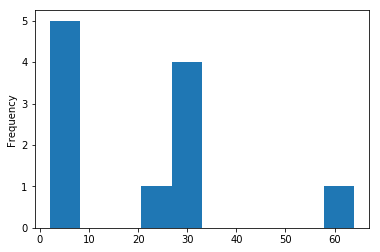

In [314]:
df.card1.value_counts().head()
df.dist2[df.card1 ==7919].median()
df.dist2[df.card1 ==7919].mode()
df.dist2[df.card1 ==7919].mean()
df.dist2[df.card1 ==7919].plot(kind = 'hist')

# these are distances probably between merchant location zip code and billing zip code, and Ip address location zip code and billing zip code.
#### since they are expected to show trends to learn in our model, we should use the median (mode is not used as its a continuous variable, an dmean is not used as it is suceptible to outliers)

In [315]:
def crossfill_median(df, list_index, fill_columns, link_with):
    
    print(f"Count of NaN's in features before filling:")
    print(df[fill_columns].isnull().sum())
    
    temp = df.pivot_table(index =list_index, values = fill_columns, aggfunc = np.median)
    temp.reset_index(inplace = True)
    print(temp.head())
    for feature in fill_columns:
        print(f' filling-in {feature} Nulls')
        df[feature] = df.apply(
            lambda row: temp[feature][(temp[link_with] == row[link_with])].median() if (pd.isnull(row[feature]))  else row[feature],axis=1) 
    print(f"Count of NaN's in features after filling:")
    print(df[fill_columns].isnull().sum())
    return df

In [316]:
dfcopy = df.copy()

list_index = ['card1']
link_with = 'card1'
fill_columns = ['dist1', 'dist2']

#fill nulls
df = crossfill_median(df, list_index, fill_columns, link_with)

Count of NaN's in features before filling:
dist1    352271
dist2    552913
dtype: int64
   card1  dist1  dist2
0   1001   11.0    NaN
1   1009    NaN   19.0
2   1011   12.0    NaN
3   1012   15.0   18.0
4   1013    3.0    NaN
 filling-in dist1 Nulls
 filling-in dist2 Nulls
Count of NaN's in features after filling:
dist1     81605
dist2    139195
dtype: int64


In [317]:
#filling rest of the nulls with median of the column.
fill_columns = ['dist1', 'dist2']
for feature in fill_columns:
    df[feature]=df[feature].fillna(df[feature].median())
print(f"Count of NaN's in features after filling D columns:")
print(df[fill_columns].isnull().sum().sum())

Count of NaN's in features after filling D columns:
0


## continuing with Nulls in cols after 45

In [319]:
starting_summary[46:56]

,feature_name,dtype,unique_values,records,nulls,%nulls,%not_nulls,%fraud_rows,%fraud_in_nulls,%fraud_in_not_nulls
46,M1,object,3,590540,271100,45.907136,54.092864,3.499001,5.282553,1.985349
47,M2,object,3,590540,271100,45.907136,54.092864,3.499001,5.282553,1.985349
48,M3,object,3,590540,271100,45.907136,54.092864,3.499001,5.282553,1.985349
49,M4,object,4,590540,281444,47.658753,52.341247,3.499001,1.857208,4.993918
50,M5,object,3,590540,350482,59.349409,40.650591,3.499001,3.735998,3.152988
51,M6,object,3,590540,169360,28.678836,71.321164,3.499001,7.068375,2.063726
52,M7,object,3,590540,346265,58.635317,41.364683,3.499001,4.576264,1.971958
53,M8,object,3,590540,346252,58.633115,41.366885,3.499001,4.576436,1.971853
54,M9,object,3,590540,346252,58.633115,41.366885,3.499001,4.576436,1.971853
55,V1,float64,3,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748


# Handling Nulls in M columns

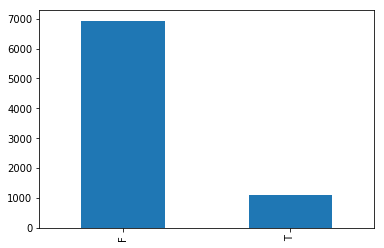

In [341]:
df.M7[df.card1 == 7919].value_counts().plot(kind = 'bar')


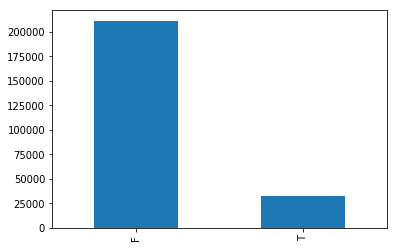

In [340]:
#distribution of M7 for all cards
df.M7.value_counts().plot(kind = 'bar')

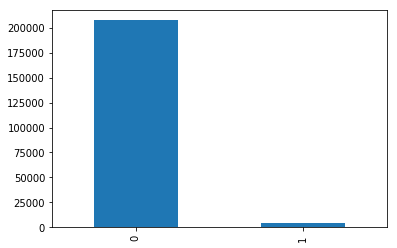

In [343]:
df.isFraud[df.M7 == 'F'].value_counts().plot(kind = 'bar')

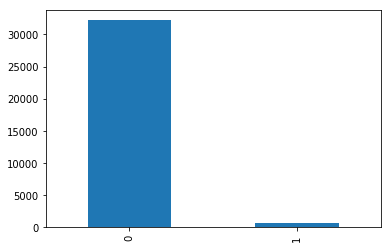

In [344]:
df.isFraud[df.M7 == 'T'].value_counts().plot(kind = 'bar')

In [348]:
#We do not see any correlation and M1-M9 are address etc static information, may be we should drop them. 
# But in general M Nulls show higher fraud% rate in comparison to not Nulls M
# do we have a credible criterea for filling nulls?

-0.04813303508865737

In [349]:
#### best is could think of is to fill with unknown
fill_columns = ['M1','M2','M3','M4','M5','M6','M7','M8','M9'] 
for feature in fill_columns:
    df[feature]=df[feature].fillna('unknown')
print(f"Count of NaN's in features after filling M columns:")
print(df[fill_columns].isnull().sum().sum())

Count of NaN's in features after filling M columns:
0


## Nulls in V Columns
The V columns looks really messy at first glance, let alone that there are 339 columns in all.

However, after a really simple null ratio check, we can find that there are actually some "blocks" in the V columns.

For example, for V1 ~ V11, 47.29% is null in training data, while 34.84% is null in test data. V12 ~ V34 have 12.88% as null in training, 2.48% as null in test, etc.

I can't help thinking if the null values in each "blocks" are in the same place, and yes they are. Which means the V columns in each block might come from a same source feature. I listed them as following:
V1 ~ V11
V12 ~ V34
V12 ~ V34
V35 ~ V52
V53 ~ V74
V75 ~ V94
V95 ~ V137
V138 ~ V166 (high null ratio)
V167 ~ V216 (high null ratio)
V217 ~ V278 (high null ratio, 2 different null ratios)
V279 ~ V321 (2 different null ratios)
V322 ~ V339 (high null ratio)

Besides, for those columns with lower null ratios, each block has one column that is binary (0 or 1), they are V1, V14, V41, V65, V88, V107, V305.

In [352]:
starting_summary[55:100]

,feature_name,dtype,unique_values,records,nulls,%nulls,%not_nulls,%fraud_rows,%fraud_in_nulls,%fraud_in_not_nulls
55,V1,float64,3,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748
56,V2,float64,10,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748
57,V3,float64,11,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748
58,V4,float64,8,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748
59,V5,float64,8,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748
60,V6,float64,11,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748
61,V7,float64,11,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748
62,V8,float64,10,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748
63,V9,float64,10,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748
64,V10,float64,6,590540,279287,47.293494,52.706506,3.499001,5.212201,1.961748


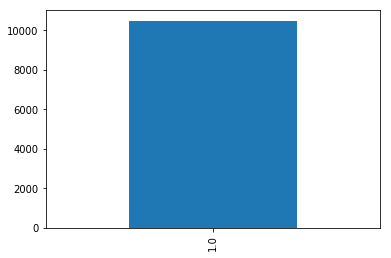

In [355]:
df.V1[df.card1 == 7919].value_counts().plot(kind = 'bar')


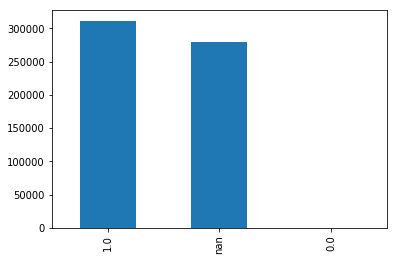

In [378]:
df.V1.value_counts(dropna = False).plot(kind = 'bar')

In [372]:
df.V12[df.card1 == 7919].value_counts(dropna = False)
df.V12[df.card1 == 7919].isnull().sum()


1.0    9821
0.0    4908
2.0     128
NaN      70
3.0       5
Name: V12, dtype: int64

70

In [381]:
#Create list of all V features
fill_columns = [x for x in df.columns.tolist() if x.startswith('V')]


In [389]:
# Function to get basic details about dataframe features
def get_value_counts(df, features):

    top5_values = {'feature_name':[],
                   'value1_name':[],'value1_count':[],
                   'value2_name':[],'value2_count':[],
                   'value3_name':[],'value3_count':[],
                   'value4_name':[],'value4_count':[],
                   'value5_name':[],'value5_count':[]
                  }
    for feature in features:
        
        values = df[feature].value_counts(dropna = False).nlargest(5).index.tolist()
        counts = df[feature].value_counts(dropna = False).nlargest(5).tolist()
        while len(values)<5:
            values.append('no_value')
            counts.append(0)

        top5_values['feature_name'].append(feature)
        top5_values['value1_name'].append(values[0])
        top5_values['value1_count'].append(counts[0])
        top5_values['value2_name'].append(values[1])
        top5_values['value2_count'].append(counts[1])
        top5_values['value3_name'].append(values[2])
        top5_values['value3_count'].append(counts[2])
        top5_values['value4_name'].append(values[3])
        top5_values['value4_count'].append(counts[3])
        top5_values['value5_name'].append(values[4])
        top5_values['value5_count'].append(counts[4])

    top5_value_counts = pd.DataFrame(top5_values)    
    return top5_value_counts

In [387]:
values =df.V1.value_counts().nlargest(5).index.tolist()
counts = df.V1.value_counts().nlargest(5).tolist()
while len(values)<5:
    values.append('empty')
    counts.append(0)
values, counts

([1.0, 0.0, 'empty', 'empty', 'empty'], [311236, 17, 0, 0, 0])

In [390]:
fill_columns = [x for x in df.columns.tolist() if x.startswith('V')]
V_analysis = get_value_counts(df, fill_columns)
V_analysis

,feature_name,value1_name,value1_count,value2_name,value2_count,value3_name,value3_count,value4_name,value4_count,value5_name,value5_count
0,V1,1.0,311236,NaN,279287,0.0,17,no_value,0,no_value,0
1,V2,1.0,298894,NaN,279287,2.0,10926,3,1181,4,163
2,V3,1.0,290583,NaN,279287,2.0,17763,3,2335,4,403
3,V4,NaN,279287,1.000000,246500,0.0,56687,2,7385,3,564
4,V5,NaN,279287,1.000000,242883,0.0,54276,2,12610,3,1200
5,V6,1.0,298627,NaN,279287,2.0,11319,3,1044,4,180
6,V7,1.0,291485,NaN,279287,2.0,17464,3,1823,4,337
7,V8,1.0,303466,NaN,279287,2.0,7076,3,553,4,95
8,V9,1.0,299625,NaN,279287,2.0,10544,3,848,4,172
9,V10,NaN,279287,0.000000,170281,1.0,137743,2,3042,3,180


### from above analysis it seem safe to use fill strategy 
(1) replacing nulls in V columns with mode for corresponsing card1 (mode is used as these are columns with most of the value counts hovering around few values only.)
(2) fill balance nulls with mode of teh columns

However since (1) above is going to take hours for more than 300 features. we should have an efficient strategy. Lets check if card number/type makes any difference to the mode value. It was evident from above table that it does not. lets check once again

In [404]:
# Just save this code for future use (we are not using here)
def crossfill_mode(df, list_index, fill_columns, link_with):
    
    print(f"Count of total NaN's in selected features before filling:")
    print(df[fill_columns].isnull().sum().sum())

    for feature in fill_columns:
        print(f' filling-in {feature} Nulls')
        df[feature] = df.apply(
            lambda row: df[feature][(df[link_with] == row[link_with])].mode()[0] 
            if ((pd.isnull(row[feature])) and (len(df[feature][(df[link_with] == row[link_with])].mode()) !=0)) else row[feature],axis=1) 
    print(f"Count of NaN's in features after filling:")
    print(df[fill_columns].isnull().sum())
    return df

In [ ]:
# Below code checks all V features for their value counts distribution (specific card/card agency/debit/credit etc)
fill_columns = [x for x in df.columns.tolist() if x.startswith('V')][0:3]

for feature in fill_columns:
    print("for specific card 7719")
    df[feature][df.card1 == 7919].value_counts(dropna = False)
    
    print("for visa")
    df[feature][df.card4 == 'visa'].value_counts(dropna = False)

    print("for mastercard")
    df[feature][df.card4 == 'mastercard'].value_counts(dropna = False)
    
    print("for credit")
    df[feature][df.card4 == 'credit'].value_counts(dropna = False)
    
    print("for debit")
    df[feature][df.card6 == 'debit'].value_counts(dropna = False)
    
    print("for all")
    df[feature].value_counts(dropna = False)
    a = input('next?')

a few runs from above code shows that we can simplu fill in using mode of teh entire column as value counts split highest ranking value remain same for various combinations

In [503]:
# dfcopy = df.copy()
fill_columns = [x for x in df.columns.tolist() if x.startswith('V')]

for feature in fill_columns:
    print(f"Nulls in {feature} being replaced with mode")
    df[feature]=df[feature].fillna(df[feature].mode()[0])
print(f"Count of NaN's in features after filling V columns:")
print(df[fill_columns].isnull().sum().sum())


Nulls in V1 being replaced with mode
Nulls in V2 being replaced with mode
Nulls in V3 being replaced with mode
Nulls in V4 being replaced with mode
Nulls in V5 being replaced with mode
Nulls in V6 being replaced with mode
Nulls in V7 being replaced with mode
Nulls in V8 being replaced with mode
Nulls in V9 being replaced with mode
Nulls in V10 being replaced with mode
Nulls in V11 being replaced with mode
Nulls in V12 being replaced with mode
Nulls in V13 being replaced with mode
Nulls in V14 being replaced with mode
Nulls in V15 being replaced with mode
Nulls in V16 being replaced with mode
Nulls in V17 being replaced with mode
Nulls in V18 being replaced with mode
Nulls in V19 being replaced with mode
Nulls in V20 being replaced with mode
Nulls in V21 being replaced with mode
Nulls in V22 being replaced with mode
Nulls in V23 being replaced with mode
Nulls in V24 being replaced with mode
Nulls in V25 being replaced with mode
Nulls in V26 being replaced with mode
Nulls in V27 being re

Nulls in V214 being replaced with mode
Nulls in V215 being replaced with mode
Nulls in V216 being replaced with mode
Nulls in V217 being replaced with mode
Nulls in V218 being replaced with mode
Nulls in V219 being replaced with mode
Nulls in V220 being replaced with mode
Nulls in V221 being replaced with mode
Nulls in V222 being replaced with mode
Nulls in V223 being replaced with mode
Nulls in V224 being replaced with mode
Nulls in V225 being replaced with mode
Nulls in V226 being replaced with mode
Nulls in V227 being replaced with mode
Nulls in V228 being replaced with mode
Nulls in V229 being replaced with mode
Nulls in V230 being replaced with mode
Nulls in V231 being replaced with mode
Nulls in V232 being replaced with mode
Nulls in V233 being replaced with mode
Nulls in V234 being replaced with mode
Nulls in V235 being replaced with mode
Nulls in V236 being replaced with mode
Nulls in V237 being replaced with mode
Nulls in V238 being replaced with mode
Nulls in V239 being repla

MemoryError: 

## Nulls in id columns

In [415]:
starting_summary[394:]
# fraud distribution in nulls for all id columns is lower than not_nulls, 
#so a bad filling strategy may not make much impact(is this correct?)

,feature_name,dtype,unique_values,records,nulls,%nulls,%not_nulls,%fraud_rows,%fraud_in_nulls,%fraud_in_not_nulls
394,id_01,float64,78,590540,446307,75.576083,24.423917,3.499001,2.093850,7.847025
395,id_02,float64,115656,590540,449668,76.145223,23.854777,3.499001,2.099549,7.966097
396,id_03,float64,25,590540,524216,88.768923,11.231077,3.499001,2.585003,10.723117
397,id_04,float64,16,590540,524216,88.768923,11.231077,3.499001,2.585003,10.723117
398,id_05,float64,94,590540,453675,76.823755,23.176245,3.499001,2.133906,8.023965
399,id_06,float64,102,590540,453675,76.823755,23.176245,3.499001,2.133906,8.023965
400,id_07,float64,85,590540,585385,99.127070,0.872930,3.499001,3.457041,8.263822
401,id_08,float64,95,590540,585385,99.127070,0.872930,3.499001,3.457041,8.263822
402,id_09,float64,47,590540,515614,87.312290,12.687710,3.499001,2.489459,10.446307
403,id_10,float64,63,590540,515614,87.312290,12.687710,3.499001,2.489459,10.446307


In [460]:
### Lest check the value counts split
fill_columns = [x for x in df.columns.tolist() if x.startswith('id')]
id_analysis = get_value_counts(df, fill_columns)
id_analysis

,feature_name,value1_name,value1_count,value2_name,value2_count,value3_name,value3_count,value4_name,value4_count,value5_name,value5_count
0,id_01,NaN,446307,-5,82170,0,19555,-10,11257,-20,11211
1,id_02,NaN,449668,1102,11,696,10,1116,9,1120,9
2,id_03,NaN,524216,0,63903,1,863,3,668,2,421
3,id_04,NaN,524216,0,65739,-5,132,-6,98,-8,64
4,id_05,NaN,453675,0,92743,1,8293,2,4937,3,3854
5,id_06,NaN,453675,0,91325,-1,4687,-5,3849,-6,3257
6,id_07,NaN,585385,0,409,16,245,14,228,12,208
7,id_08,NaN,585385,-100,500,0,261,-34,257,-33,209
8,id_09,NaN,515614,0,70378,1,1616,3,966,2,773
9,id_10,NaN,515614,0,72879,-6,295,-5,247,-1,200


In [423]:
for feature in df.columns.tolist():
    
    if (df[feature].dtype != 'O') and (df[feature].corr(df.isFraud) >.25):
        print (f"{feature}:{df[feature].corr(df.isFraud)}")

isFraud:1.0
V44:0.2603761673461998
V45:0.28183194637643094
V86:0.25182798642395265
V87:0.2517374422127143
V149:0.2732821052990537
V156:0.2759520895145737
V158:0.2780662447880996
V188:0.30358227133771953
V189:0.3082194603691243
V200:0.3187825140584449
V201:0.32800503459815444
V228:0.2688609827818419
V242:0.360590490265958
V244:0.3641291589611914
V246:0.3668776990983728
V257:0.38305975102060286
V258:0.29715149798963714


In [467]:
# make a list of features where highest vale count among no nulls are covered by single value
id_fill = {}
id90 = []
for feature in fill_columns:

    x = 100*df[feature].value_counts().nlargest(1)/(df.shape[0]-df[feature].isnull().sum())

    if x.iloc[0]>=90:
        print (f"{feature}:value '{x.index[0]}' covers {round(x.iloc[0], 2)}% not_nulls")
        new = {feature:x.index[0]}
        id_fill.update(new)
        id90.append(feature)
    # perhaps we can fill if % of highest value count is >90%

id_03:value '0.0' covers 99.59% not_nulls
id_04:value '0.0' covers 99.9% not_nulls
id_09:value '0.0' covers 99.23% not_nulls
id_10:value '0.0' covers 99.65% not_nulls
id_11:value '100.0' covers 98.68% not_nulls
id_22:value '14.0' covers 99.93% not_nulls
id_27:value 'Found' covers 100.0% not_nulls
id_36:value 'F' covers 98.83% not_nulls


In [462]:
id_fill

{'id_03': 0.0,
 'id_04': 0.0,
 'id_09': 0.0,
 'id_10': 0.0,
 'id_11': 100.0,
 'id_22': 14.0,
 'id_27': 'Found',
 'id_36': 'F'}

In [463]:
for feature in id90:
    print(f"nulls in {feature} being replaced with {id_fill[feature]}")
    df[feature]=df[feature].fillna(id_fill[feature])
print(f"Count of NaN's in features after filling V columns:")
print(df[fill_columns].isnull().sum().sum())
    

nulls in id_03 being replaced with 0.0
nulls in id_04 being replaced with 0.0
nulls in id_09 being replaced with 0.0
nulls in id_10 being replaced with 0.0
nulls in id_11 being replaced with 100.0
nulls in id_22 being replaced with 14.0
nulls in id_27 being replaced with Found
nulls in id_36 being replaced with F
Count of NaN's in features after filling V columns:
14885264


In [487]:
# filling in 'object type column nulls with 'unknown'
to_delete_id = list(set(fill_columns)-set(id90))
new_fill_columns = df[to_delete_id].select_dtypes(include='object').columns.tolist()
for feature in new_fill_columns:
    df[feature]=df[feature].fillna('unknown')

In [488]:
# deleting rest of the id fields as we do not have much info to fill nulls
delete = list(set(to_delete_id)-set(new_fill_columns))
df = df.drop(delete, axis =1)

In [470]:
df.DeviceType.value_counts(dropna = False)
df.DeviceInfo.value_counts(dropna = False)

NaN        449730
desktop     85165
mobile      55645
Name: DeviceType, dtype: int64

NaN                               471874
Windows                            47722
iOS Device                         19782
MacOS                              12573
Trident/7.0                         7440
rv:11.0                             1901
rv:57.0                              962
SM-J700M Build/MMB29K                549
SM-G610M Build/MMB29K                461
SM-G531H Build/LMY48B                410
rv:59.0                              362
SM-G935F Build/NRD90M                334
SM-G955U Build/NRD90M                328
SM-G532M Build/MMB29T                316
ALE-L23 Build/HuaweiALE-L23          312
SM-G950U Build/NRD90M                290
SM-G930V Build/NRD90M                274
rv:58.0                              269
rv:52.0                              256
SAMSUNG                              235
SM-G950F Build/NRD90M                225
Moto G (4) Build/NPJ25.93-14.7       219
SM-N950U Build/NMF26X                209
SM-A300H Build/LRX22G                203
hi6210sft Build/

In [471]:
df.DeviceType[df.isFraud ==1].value_counts(dropna = False)[0:10]
df.DeviceInfo[df.isFraud ==1].value_counts(dropna = False)[0:10]

NaN        9452
mobile     5657
desktop    5554
Name: DeviceType, dtype: int64

NaN                          12056
Windows                       3121
iOS Device                    1240
MacOS                          278
hi6210sft Build/MRA58K         180
SM-A300H Build/LRX22G          169
rv:57.0                        103
Trident/7.0                     96
rv:11.0                         76
LG-D320 Build/KOT49I.V10a       61
Name: DeviceInfo, dtype: int64

In [473]:
df.DeviceType = df.DeviceType.fillna('unknown')
df.DeviceInfo = df.DeviceInfo.fillna('unknown')

In [504]:
df.isnull().sum().sum()

0